In [2]:
import warnings
import gc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import seaborn as sns
import glob

In [3]:
pd.set_option('display.max_columns', None)

## Funções

In [4]:
def input_na(data):
    
    def get_low_q(col):
      return data[col].quantile(0.01)
    # Tratando dados faltantes
    data.NT_MEDIA = data.NT_MEDIA.fillna(get_low_q('NT_MEDIA'))
    data.NU_NOTA_MT = data.NU_NOTA_MT.fillna(get_low_q('NU_NOTA_MT'))
    data.NU_NOTA_LC = data.NU_NOTA_LC.fillna(get_low_q('NU_NOTA_LC'))
    data['LOG_NT_MEDIA'] = np.log(data.NT_MEDIA)
    data['LOG_NT_MT'] = np.log(data.NU_NOTA_MT)
    data['LOG_NT_LC'] = np.log(data.NU_NOTA_LC)

    data['Q025'] = np.where((data['Q024']!=0) & (data['Q022']!=0) & (data['Q025']!=0), 1, data['Q025'])
    imp = data['Q005'].mean()
    data['Q005'] = np.where(data['Q005'].isna(), imp, data['Q005'])

    data.replace([np.inf, -np.inf], 0, inplace=True)
    
    return data

In [26]:
def pipeline(data):

    data['NAO_BRANCO'] = np.where(~data['TP_COR_RACA'].isin([1,4]), 1, 0)
    data['MULHER'] = np.where(data['TP_SEXO'] == 'F', 1, 0)
    data.drop(columns=['TP_SEXO'], inplace=True)

    data.Q002 = data.Q002.fillna('H')
    data.Q001 = data.Q001.fillna('H')
    #data.Q006 = data.Q006.fillna(0)

    data.IND_CASA = data.IND_CASA.fillna(0)
    data.IND_CASA = data.IND_CASA.apply(lambda x: np.round(x, 2))
    data['SOLTEIRO'] = np.where(data['TP_ESTADO_CIVIL'].isin([0,1]), 1, 0)

    data['treated'] = np.where(data['SG_UF_ESC'].isin(['MA', 'CE', 'PA', 'PI']), 1, 0)

    le = LabelEncoder()
    for col in ['Q001', 'Q002', 'Q006', 'Q022', 'Q024']:
        arr = data[col].values
        le.fit(arr)
        data[col] = le.transform(arr)
    data.Q001 = data.Q001 + 1
    data.Q002 = data.Q002 + 1
    data.Q001 = data.Q001.replace(8,0)
    data.Q002 = data.Q002.replace(8,0)

    data['Q025'] = np.where((data['Q024']!=0) & (data['Q022']!=0) & (data['Q025']!=0), 1, data['Q025'])
    imp = data['Q005'].mean()
    data['Q005'] = np.where(data['Q005'].isna(), imp, data['Q005'])

    data.dropna(subset=['NT_MEDIA'], inplace=True)

    # Selecionando apenas escolas públicas e privadas
    data = data[data['TP_ESCOLA']!=1]
    data['ESCOLA_PUBLICA'] = np.where(data['TP_ESCOLA']==2,1,0)

    return data

In [6]:
def return_nan(df):
    na_cols = list()
    for col in df.columns:
        if df[col].isna().any():
            print(col, df[col].isna().sum())
            na_cols.append(col)
    return na_cols

In [7]:
def fit_model(model, q):
    res = model.fit(
        q=q, 
        vcov='robust',
        kernel='epa',
        bandwidth='hsheather', 
        max_iter=1000,
        p_tol=1e-06
    )

    return res.summary()

In [8]:
def create_model(df, cols):
  mod = smf.quantreg(cols, data=df, missing='drop')
  return mod

# Prepara dados

In [27]:
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

In [3]:
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching_individual-20-21.parquet')

In [6]:
data.Q025.unique()

array([1., 0.])

In [28]:
data = pipeline(data)

/tmp/ipykernel_69796/2599018342.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ESCOLA_PUBLICA'] = np.where(data['TP_ESCOLA']==2,1,0)


In [29]:
na_cols = return_nan(data)
#data.dropna(subset=['CO_MUNICIPIO_ESC'], inplace=True)

CO_MUNICIPIO_ESC 696891
NO_MUNICIPIO_ESC 696891
SG_UF_ESC 696891
TP_DEPENDENCIA_ADM_ESC 696891
TP_ESTADO_CIVIL 19360
TP_LOCALIZACAO_ESC 696891


In [30]:
data.groupby('NU_ANO').size()

NU_ANO
2018.0     981852
2019.0    1111841
2020.0     763362
2021.0     742561
dtype: int64

 Selecionando alunos de escola públicas estaduais dos municípios tratados. Hipótese de exogeneidade

In [14]:
#pub = data[(data.TP_ESCOLA==2) & (data.treated == 1)]

In [31]:
data.query('NU_ANO==2020').Q025.isna().sum()

0

In [32]:
data.query('NU_ANO==2020 or NU_ANO==2021').to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_matching_individual-20-21.parquet')

# Regressão

In [15]:
def extract_output(response):
  # Extraindo resultados
  vars_dict = {
    'Q001':'EDUCAÇÃO PAI',
    'Q002':'EDUCAÇÃO MÃE',
    'Q005':'QTD PESSOAS CASA',
    'Q006':'RENDA FAMILIAR',
    'Q022':'POSSUI CELULAR',
    'Q024': 'POSSUI COMPUTADOR',
    'Q025': 'ACESSO INTERNET',
    'const':'Intercept'
    }

  if isinstance(response, dict):
    # QReg
    dfs = []
    metadatas = []  

    for k, v in response.items():
      # Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
      results_as_html = v.tables[1].as_html()
      metadata = v.tables[0].as_html()
      metadata = pd.read_html(metadata, header=0, index_col=0)[0]
      df = pd.read_html(results_as_html, header=0, index_col=0)[0]
      df['quantile'] = k
      metadata['quantile'] = k
      dfs.append(df)
      metadatas.append(metadata)
  
    all = pd.concat(dfs)
    meta = pd.concat(metadatas, axis=1)
    all = all.reset_index().rename(columns={'index':'vars'})
    all.vars = all.vars.replace(vars_dict)
    return all, meta

  else:
    # LinearReg
    df = pd.read_html(response.summary().tables[1].as_html(), header=0, index_col=0)[0]
    meta = pd.read_html(response.summary().tables[0].as_html(), header=0, index_col=0)[0]
    df = df.reset_index().rename(columns={'index':'vars'})
    df.vars = df.vars.replace(vars_dict)
    return df, meta

In [16]:
def run_models(df, y_col, file_name=None):
  index_vars = ['NU_ANO', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC']
  dependent_vars = ['NU_NOTA_LC', 'NU_NOTA_MT', 'NT_MEDIA', 'LOG_NT_MEDIA', 'LOG_NT_MT', 'LOG_NT_LC']
  independent_vars = [col for col in df.columns if col not in dependent_vars + index_vars]
  formula = f"{y_col} ~ {' + '.join(independent_vars)}"
  print(formula)
  qreg = create_model(df, formula)
  lm = sm.OLS(df[y_col], sm.add_constant(df[independent_vars]), missing='drop')

  # Fit no modelo
  quantiles = np.arange(0.05, 0.96, 0.05)
  models = {x: fit_model(qreg, x) for x in quantiles}
  res = lm.fit()

  all, meta = extract_output(models)
  lin_df, lin_meta = extract_output(res)

  # Agregando em dicionário
  result = {
      'lm': [lin_df, lin_meta],
      'qreg': [all, meta]
  }

  return result

In [17]:
def plot_regression(qreg, lm, year):
  fig, ax = plt.subplots(5,3, figsize=(10,16))
  ax = ax.flatten()
  sns.set_style('whitegrid', {"grid.color": ".9"})
  for i, col in enumerate(qreg.vars.unique()):
    sel = qreg[qreg['vars']==col]
    sel_lm = lm[lm['vars']==col]
    lm_y = np.repeat(sel_lm['coef'], len(sel))
    #sns.scatterplot(data=sel, x=sel['quantile'], y=sel['coef'], ax=ax[i])
    ax[i].plot(sel['quantile'], sel['coef'])
    ax[i].plot(sel['quantile'], lm_y, color='r', alpha=0.8, linestyle='-.')
    ax[i].fill_between(sel['quantile'],sel['[0.025'], sel['0.975]'], alpha=0.1, color='b')
    ax[i].set_xlabel('Quantil')
    ax[i].set_ylabel('Coef')
    ax[i].set_title(col)
    #ax[i].set_ylim([-0.3,0.3])
  fig.delaxes(ax[-1])
  fig.suptitle(f'Coeficientes de Regressão Quantílias e Lineares para Notas Médias do Enem - {year}', fontsize=12, weight='bold')
  plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
  plt.show()

In [18]:
def run_linear(df, y_col, file_name=None):
  index_vars = ['NU_ANO', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC']
  dependent_vars = ['NU_NOTA_LC', 'NU_NOTA_MT', 'NT_MEDIA', 'LOG_NT_MEDIA', 'LOG_NT_MT']
  independent_vars = [col for col in df.columns if col not in dependent_vars + index_vars]
  lm = sm.OLS(df[y_col], sm.add_constant(df[independent_vars]), missing='drop')
  res = lm.fit()
  lin_df, lin_meta = extract_output(res)

  return lin_df, lin_meta


In [19]:
def concat_evolution(dict):
  data=[]
  for k in dict.keys():
    df = dict[k][0]
    df['ano'] = k
    data.append(df)
  return pd.concat(data).reset_index(drop=True)

Testando com todos os indivíduos inicialmente

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


LOG_NT_MEDIA ~ TP_FAIXA_ETARIA + Q001 + Q002 + Q005 + Q006 + Q022 + Q024 + Q025 + IND_CASA + NAO_BRANCO + MULHER + SOLTEIRO + ESCOLA_PUBLICA


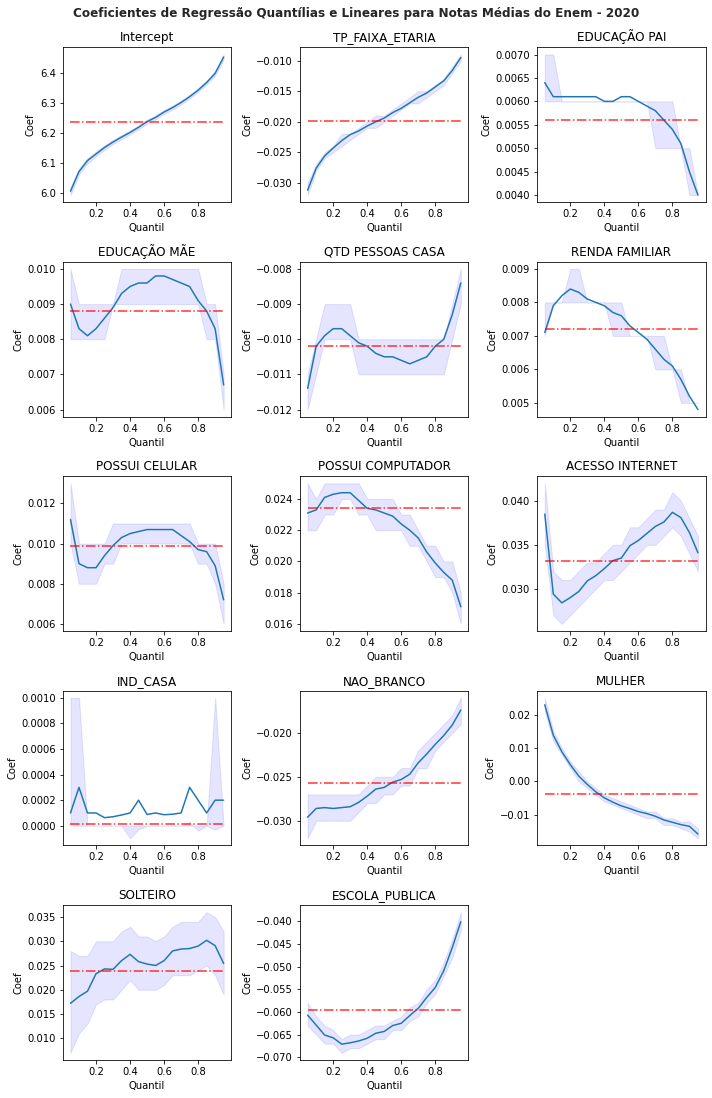

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


LOG_NT_MEDIA ~ TP_FAIXA_ETARIA + Q001 + Q002 + Q005 + Q006 + Q022 + Q024 + Q025 + IND_CASA + NAO_BRANCO + MULHER + SOLTEIRO + ESCOLA_PUBLICA


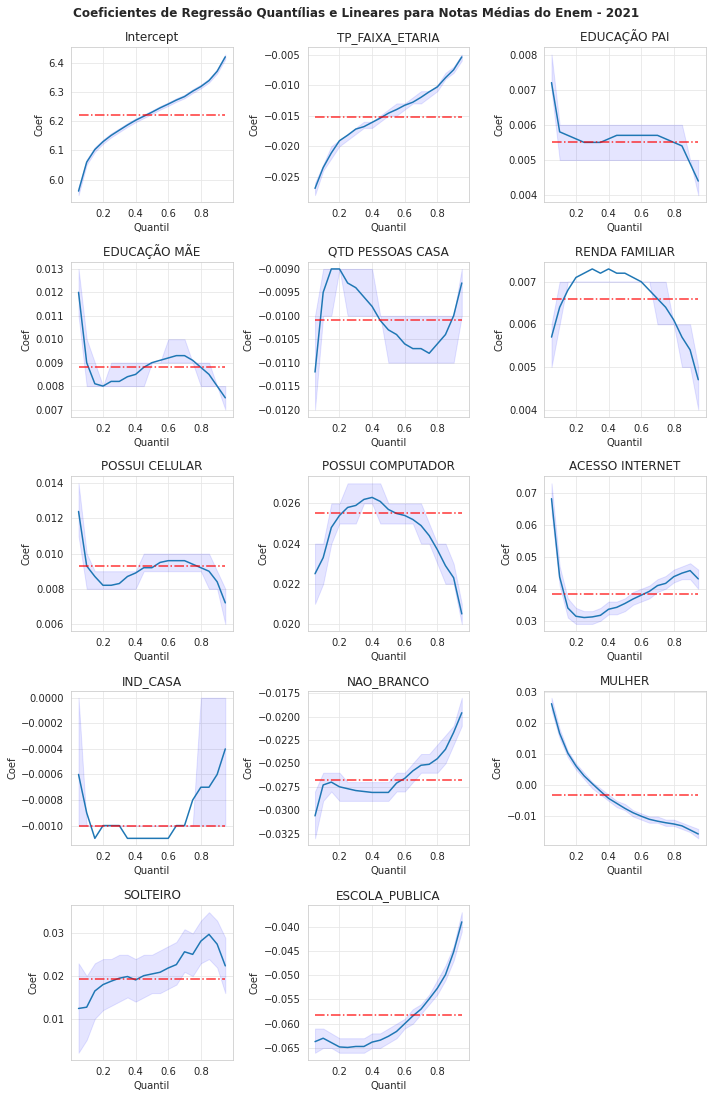

In [21]:
for ano in range(2020,2021+1):
    df = data[(~data.isin([np.nan, np.inf, -np.inf]).any(1)) & (data['NU_ANO']==ano)]
    df.drop(columns=[ 'TP_DEPENDENCIA_ADM_ESC','treated', 'TP_ESTADO_CIVIL', 'TP_LOCALIZACAO_ESC', 'TP_ESCOLA', 'TP_COR_RACA'], inplace=True)
    result = run_models(df, 'LOG_NT_MEDIA')
    plot_regression(result['qreg'][0], result['lm'][0], ano)
    

## Plotando evolução histórica dos coeficientes de regressão

In [22]:
results = {}
for ano in range(2018,2021+1):
    df = data[(~data.isin([np.nan, np.inf, -np.inf]).any(1)) & (data['NU_ANO']==ano)]
    df.drop(columns=[ 'TP_DEPENDENCIA_ADM_ESC','treated', 'TP_ESTADO_CIVIL', 'TP_LOCALIZACAO_ESC', 'TP_ESCOLA', 'TP_COR_RACA'], inplace=True)
    res, meta = run_linear(df, 'LOG_NT_MEDIA')
    results[ano] = [res, meta]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

In [23]:
data.head()

,NU_ANO,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_FAIXA_ETARIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,TP_LOCALIZACAO_ESC,LOG_NT_MT,NU_NOTA_LC,NU_NOTA_MT,Q001,Q002,Q005,Q006,Q022,Q024,Q025,IND_CASA,NT_MEDIA,LOG_NT_MEDIA,NAO_BRANCO,MULHER,SOLTEIRO,treated,ESCOLA_PUBLICA
0,2018.0,1500800,Ananindeua,PA,4.0,2.0,0.0,4.0,4.0,1.0,6.207181,517.9,496.3,5,5,2.0,5,3,2,1.0,7.79,503.96,6.222497,0,1,1,1,0
2,2018.0,3155603,Rio Pardo de Minas,MG,2.0,3.0,0.0,0.0,2.0,1.0,6.017132,534.4,410.4,2,2,7.0,1,3,0,0.0,6.79,497.84,6.210279,1,0,1,0,1
3,2018.0,1500800,Ananindeua,PA,4.0,2.0,0.0,3.0,4.0,1.0,6.567375,614.5,711.5,6,6,4.0,8,3,0,1.0,7.79,675.64,6.515660,1,1,1,1,0
5,2018.0,3161106,São Francisco,MG,2.0,2.0,0.0,3.0,2.0,1.0,6.282080,512.5,534.9,5,5,3.0,3,3,0,1.0,5.79,497.78,6.210158,1,1,1,0,1
11,2018.0,2927408,Salvador,BA,2.0,2.0,0.0,0.0,2.0,1.0,6.177114,575.0,481.6,5,4,4.0,2,3,0,0.0,5.79,576.42,6.356837,1,1,1,0,1


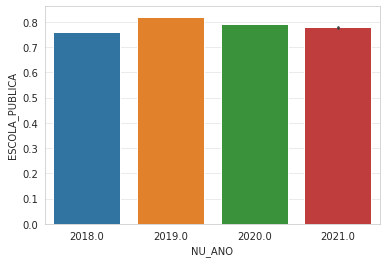

In [24]:
sns.barplot(data=data, x='NU_ANO', y='ESCOLA_PUBLICA');

In [25]:
#data.groupby(['NU_ANO', 'Q025']).plot(kind='bar')

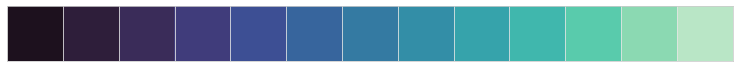

In [26]:

sns.set_palette('mako', n_colors=13)
sns.palplot(sns.color_palette(n_colors=13))

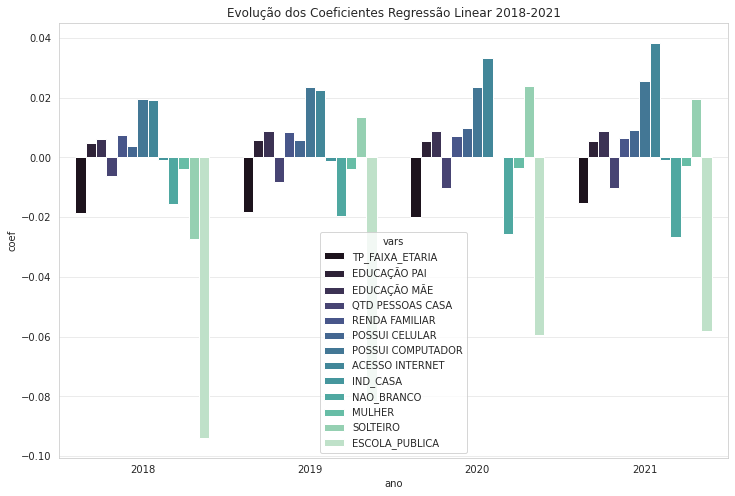

In [27]:
evolution = concat_evolution(results)
evolution = evolution.query('vars != "Intercept"')
sns.set_palette('mako', n_colors=13)
fig = plt.figure(figsize=(12,8))
#sns.lineplot(data=evolution, x='ano', y='coef', hue='vars', palette='bright', linewidth=2, markers=True)
sns.barplot(data=evolution, x='ano', y='coef', hue='vars',  dodge=True)
plt.title('Evolução dos Coeficientes Regressão Linear 2018-2021')
plt.show()